<a href="https://colab.research.google.com/github/ChristianConchari/Computer-Vision-Notes/blob/master/Tutorial_19_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 19: Transfer Learning

Deep Learning (DL) for Computer Vision has many advantages and applications in areas as healthcare, agriculture, smart cities, and so on. Nevertheless, the traditional supervised learning approach for DL breaks down when we do not have good computing resources or enough labelled data. In addition, the idea of training an AI model from scratch does not follow the human learning normal behaviour. For instance, a model trained to drive an autonomous car in the US should also work in India or Mexico. Also, a model capable of recognizing numbers should be used when trying to detect numbers on bank cheques. Transfer Learning is a broad research area that aims at transferring knowledge acquired while solving a problem for a different problem or domain.  

[ImageNet](https://www.image-net.org/) is a massive image dataset that has more than 14M labelled samples. So far, you have seen several architectures that are capable of dealing with this huge dataset. One of these is the VGG-16, which  was already trained by using high GPUs. Thus, it has already learned low level features like lines, edges, circles, shapes, features present in other domains as well. Consequently, VGG-16 can work as a feature extractor for a different problem with distinct categories. 

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width="500" align="center" />

In this tutorial, you will see how to implement Transfer Learning  with PyTorch to detect Pneumonia using Chest X-Ray Images. Pneumonia is an infection in one or both lungs that causes inflammation and fluids accumulation. It is caused by bacteria and viruses but it is not fatal nowadays for healthy people, otherwise, people can have serious problems. From a computer vision perspective, the most important symptom is the occurrence of patchy consolidations, mainly in the right upper lobe (arrow). These can be visualised by x-ray images and will be the way we will detect pneumonia in patients. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Chest_radiograph_in_influensa_and_H_influenzae%2C_posteroanterior%2C_annotated.jpg/600px-Chest_radiograph_in_influensa_and_H_influenzae%2C_posteroanterior%2C_annotated.jpg" width="200" height="200" align="center" />

Ref: [Pneumonia definition](https://en.wikipedia.org/wiki/Pneumonia)

## 1. Import libraries and the dataset. Display samples. 

Download the dataset from Kaggle. Please follow the instructions [here](https://www.kaggle.com/general/74235).

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!ls
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

For this tutorial, we will divide the dataset into three subsets: test, train, validation. 

In [ ]:
data_dir = "chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import copy

import torch
import torch.nn as nn
import torchvision

# data loading and transforming
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets

# evaluation metrics visualisation
import seaborn as sns

# define a transform to read the data in as a tensor. A good practice when creating
# the data transforms is to use a flag to apply different preprocessing according
# to what is needed. You might also include other preprocessing functions.  
def transform_data(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform

# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)

cuda:0


In [ ]:
# add the transforms for training, validation and testing to a dict so they can be easily called
data_transforms = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform_data(x)) 
                  for x in [TRAIN, VAL, TEST]}

# prepare data loaders, set the batch_size
# consider changing the batch size because it can have effects in the accuracy of your architecture
dataloaders = {TRAIN: torch.utils.data.DataLoader(data_transforms[TRAIN], batch_size = 4, shuffle=True), 
               VAL: torch.utils.data.DataLoader(data_transforms[VAL], batch_size = 1, shuffle=True), 
               TEST: torch.utils.data.DataLoader(data_transforms[TEST], batch_size = 1, shuffle=True)}

# create a dict with the subsets' sizes
dataset_sizes = {x: len(data_transforms[x]) for x in [TRAIN, VAL]}

print("Dataset sizes: ", dataset_sizes)
classes = data_transforms[TRAIN].classes
print("Dataset classes in TRAIN: ", classes)
classes = data_transforms[VAL].classes
print("Dataset classes in VAL: ", classes)

Dataset sizes:  {'train': 5216, 'val': 16}
Dataset classes in TRAIN:  ['NORMAL', 'PNEUMONIA']
Dataset classes in VAL:  ['NORMAL', 'PNEUMONIA']


### Visualize an entire batch 

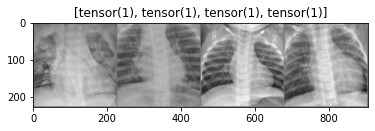

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

# obtain one batch of training images
inputs, classes = next(iter(dataloaders[TRAIN]))
out = torchvision.utils.make_grid(inputs)
# plot the images in the batch, along with the corresponding labels
imshow(out, title=[classes[x] for x in classes])

## 2. Load the pretrained model from PyTorch 

In [ ]:
# Load the pretrained model VGG-16
pretrained_model = models.vgg16(pretrained=True)
print(pretrained_model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
# freeze all the layers to implement transfer learning
for param in pretrained_model.features.parameters():
    param.required_grad = False


num_features_last_layer = pretrained_model.classifier[6].in_features
print("Num. of input nodes for the last fully-connected layer: ",num_features_last_layer)
classifier = list(pretrained_model.classifier.children())[:-1] 
print("Original classifier architecture:",classifier)

# extend the final classifier of VGG-16 to have two outputs: "NORMAL", "PNEUMONIA"
classifier.extend([nn.Linear(num_features_last_layer, len(classes))])
pretrained_model.classifier = nn.Sequential(*classifier) 
print("New classifier architecture",classifier)

Num. of input nodes for the last fully-connected layer:  4096
Original classifier architecture: [Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]
New classifier architecture [Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4, bias=True)]


### Define the optimizer and loss function

In [ ]:
import torch.optim as optim

# transfer the pretrained_model to GPU
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

As you have seen, there are many techniques to adapt constantly the behaviour of the learning rate (LR) (e.g. momentum). Sometimes, LRs can reach a plateau and stop improving, which can be unoticeable when training deep CNNs for a long time. A good practice is to decay the LR to during training by reducing the learning rate according to a pre-defined schedule. Common learning rate schedules include time-based decay, step decay and exponential decay. The following chart will help you see different behaviours of LRs when training deep CNNs. 

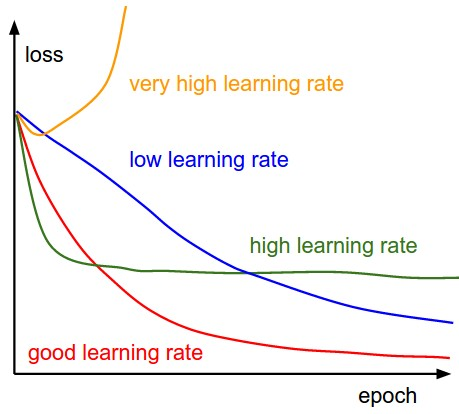

In [ ]:
# decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## 3. Train the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # iterate through the epochs
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        # train and validate for every epoch
        for phase in [TRAIN, VAL]:

            # change the mode of the pretrained model according to the stage
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # iterate through the batches
            for data in dataloaders[phase]:
                images, labels = data
                
                # transfer the images and labels to GPU 
                images = images.to(device)
                labels = labels.to(device)

                # restart the gradients
                optimizer.zero_grad()

                # enable gradients for training
                with torch.set_grad_enabled(phase==TRAIN):
                    # predict the labels
                    predicted = model(images)
                    _, preds = torch.max(predicted, 1)
                    loss = criterion(predicted, labels)

                    # backward propagation if training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # add up the losses
                running_loss += loss.item() * images.size(0)

                # add up the correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # calculate the epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # if the phase is validation and the accuracy is the best found ever, 
            # backup the weights 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load the best weights found when validating the model
    model.load_state_dict(best_model_weights)
    return model

# define the number of epochs to train for
n_epochs = 1

# call train
retrained_model = train_model(pretrained_model, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/1


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1844 Acc: 0.9321
val Loss: 0.0927 Acc: 1.0000
Best val Acc: 1.000000


## 4. Evaluate the model


In [ ]:
import torch.nn.functional as F
def test_model():

    running_correct = 0.0
    running_total = 0.0

    true_labels = []
    pred_labels = []
    ps_list = []
    
    # disable gradients.
    with torch.no_grad():

        # iterate in the test subset
        for data in dataloaders[TEST]:
            images, labels = data
            
            # transfer tensors to GPU
            images = images.to(device)
            labels = labels.to(device)

            true_labels.append(labels.item())

            # get predicted labels with the retrained model
            outputs = retrained_model(images)

            # Output of the network are logits, need to take softmax for probabilities
            ps = F.softmax(outputs, dim=1)
            ps = ps.data.cpu().numpy().squeeze()

            _, preds = torch.max(outputs.data, 1)

            pred_labels.append(preds.item())

            ps_list.append(np.max(ps))

            # calculate the accuracy
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        accuracy = running_correct/running_total

    return (true_labels, pred_labels, running_correct, running_total, accuracy, ps_list)

true_labels, pred_labels, running_correct, running_total, accuracy, ps_list = test_model()

## 5. Evaluation metrics

In [ ]:
print("Total Correct Images: {}, Total Test Images: {}".format(int(running_correct), int(running_total)))
print(f'Test Accuracy: {round(accuracy*100,2)} %')

Total Correct Images: 537, Total Test Images: 624
Test Accuracy: 86.06 %


# Exercise 1: 

This time, your task will be to **visualize 10 to 20 evaluation samples with their true and predicted labels**. Then, you will have to **show the Confusion Matrix and AUC of the model** to understand the accuracy. As you can see, the model trained with only 1 epoch but the optimal should be 30, still, it got interesting results because it had already knowledge. Finally, **increase the number of epochs** to improve the accuracy. 

## Data Visualization

We will start by defining a function to display the images to be worked together with the corresponding prediction made by the model. If the prediction coincides with the current value of the label corresponding to the image, the title will be painted green and both classes will be shown; on the other hand, if they do not coincide, they will be painted red.

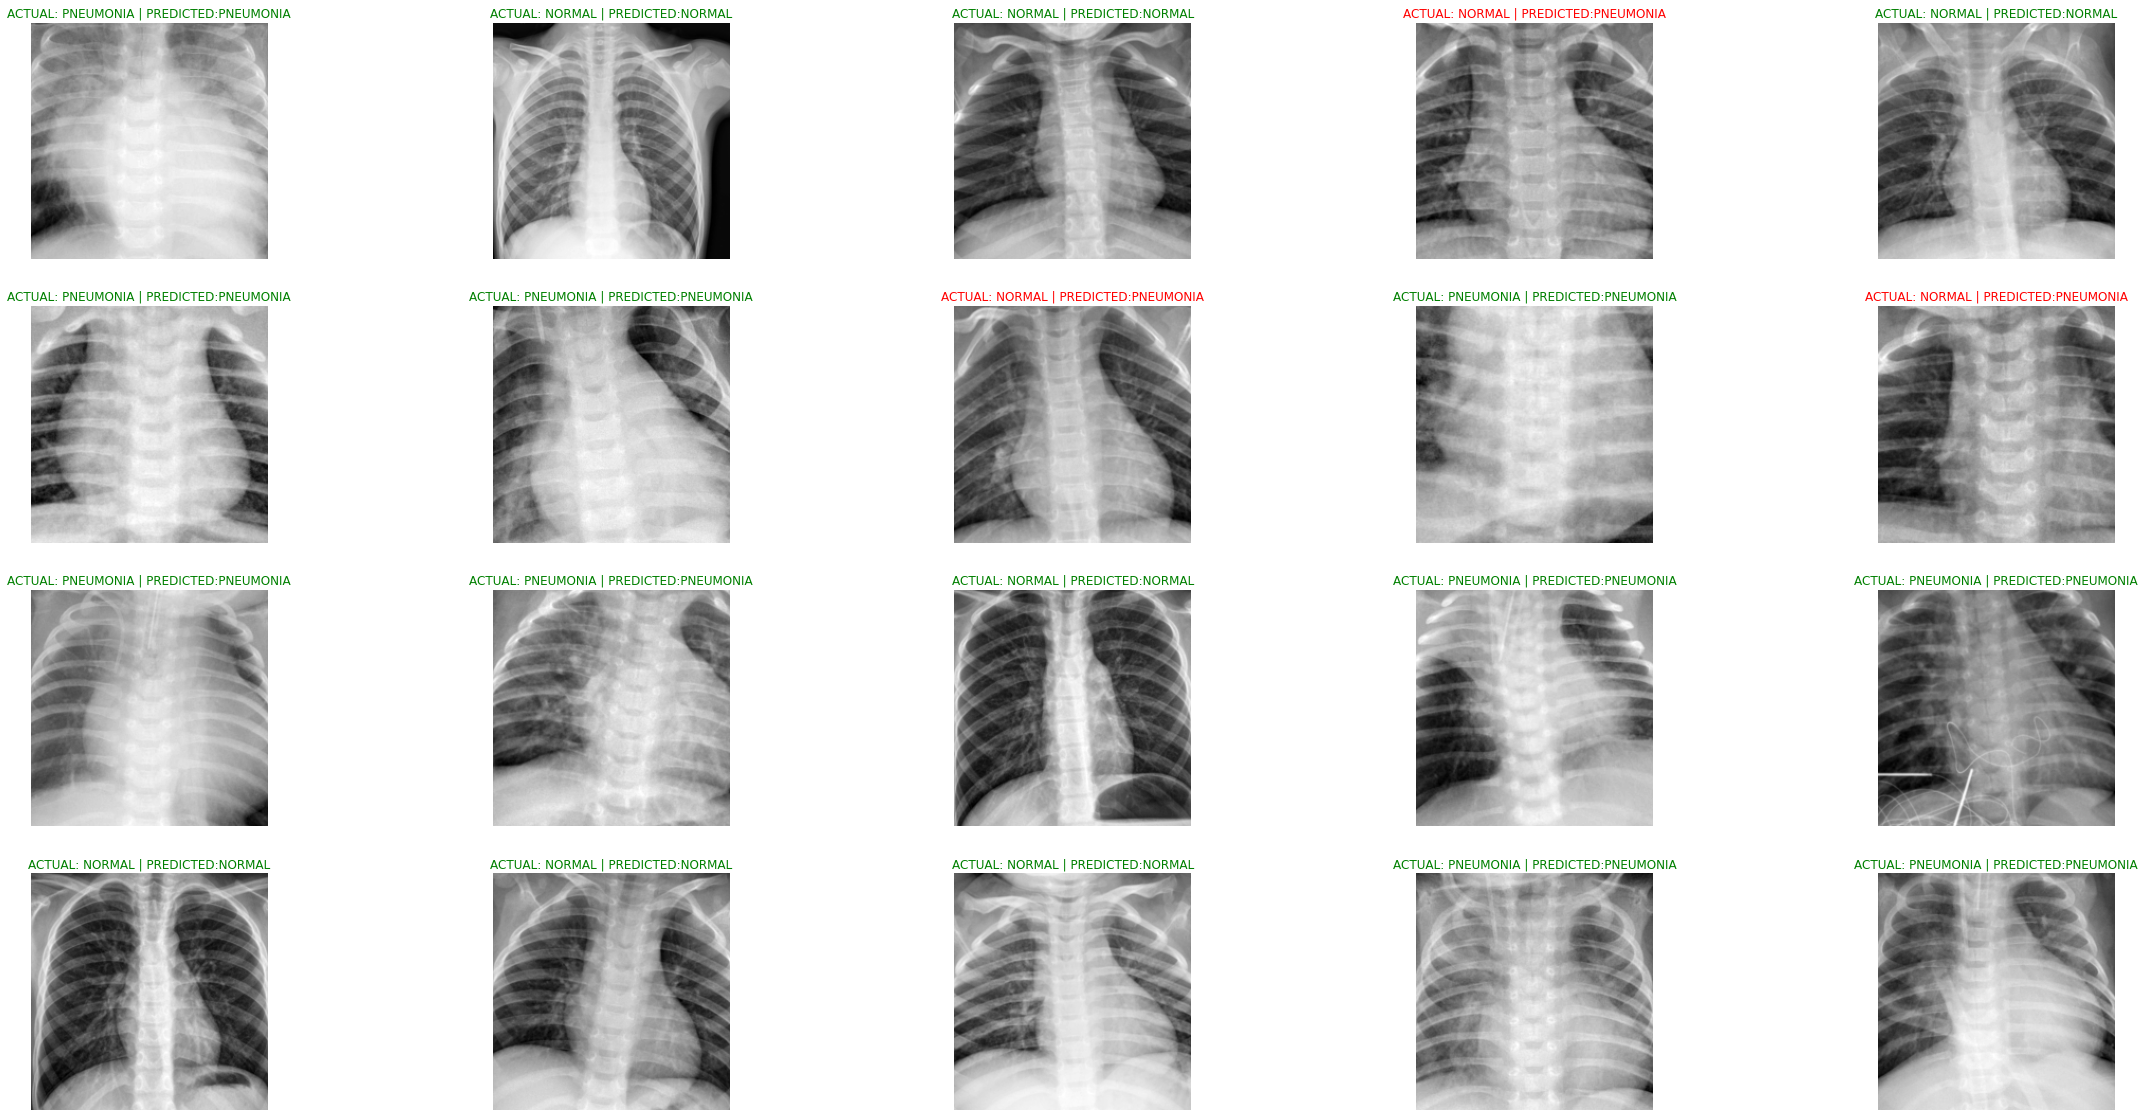

In [ ]:
def visualize_model(num_images=20):
    retrained_model.eval()
    images_handeled = 0
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(40,20))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[TEST]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            a=inputs.cpu()[0,0,:,:]

            outputs = retrained_model(inputs)
            _, preds = torch.max(outputs, 1)

            col = 'green' 
            if labels[0].item() != preds[0]:
                col = 'red'

            if labels[0].item()==0:
              actual = 'NORMAL'
            else:
              actual = 'PNEUMONIA'

            if preds[0]==0:
              predict = 'NORMAL'
            else:
              predict = 'PNEUMONIA'

            ax[images_handeled//5][images_handeled%5].imshow(a, cmap='gray')
            ax[images_handeled//5][images_handeled%5].set_title('ACTUAL: {} | PREDICTED:{}'.format(actual,predict), color=col)
            ax[images_handeled//5][images_handeled%5].axis('off')
            
            images_handeled += 1
            if images_handeled == num_images:
              break

visualize_model()
plt.show()

As we can see, the model is showing good results. Given that most of the predictions were properly made. Note that out of 20 images, the class of 17 was correctly predicted, which is consistent with the percentage of accuracy obtained in the evaluation of the model.

## Confusion Matrix

The code cells implemented to obtain the confusion matrix will be shown below.

In [ ]:
!pip install torchmetrics

     |████████████████████████████████| 276kB 17.7MB/s 


In [ ]:
from torchmetrics import ConfusionMatrix

target = torch.tensor(true_labels)
preds = torch.tensor(pred_labels)
confmat = ConfusionMatrix(num_classes=2)
mat_tensor = confmat(preds, target)
print(mat_tensor)

tensor([[154.,  80.],
        [  7., 383.]])


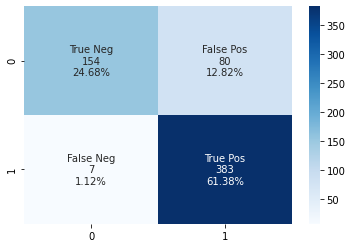

In [ ]:
import seaborn as sns
conf_mat = mat_tensor.numpy()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')

As can be seen, good results were obtained when making predictions. In the case of the model obtained, a precision of 0.8814 was achieved, as can be verified in point 5 of this notebook. And when making a sum of the percentages of the main diagonal, a value of 88.14% is obtained, verifying the results.

## Area Under the Curva

The following cell will show the implementation of the code to obtain the AUC metrics.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


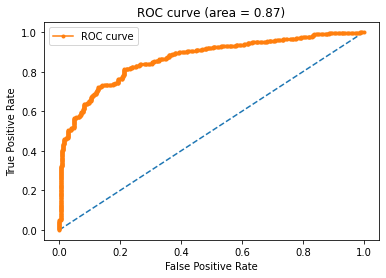

In [ ]:
from torchmetrics import ROC
from torchmetrics import AUROC
from matplotlib import pyplot

roc = ROC(pos_label=1)
auroc = AUROC(pos_label=1)

# define a tensor with probabilities
pred = torch.tensor(ps_list, dtype=torch.float64)
# define a tensor with 
target =  torch.tensor(true_labels, dtype=torch.int64)

fpr, tpr, _ = roc(pred, target)

roc_auc = auroc(pred, target).item()

pyplot.plot([0, 1], [0, 1], linestyle='--', label='')
pyplot.title('ROC curve (area = %0.2f)' % roc_auc)

pyplot.plot(fpr, tpr, marker='.', label='ROC curve')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()

Emphasizing the area under the curve that has a value greater than 0.8, this indicates the existence of good predictions in the model, so that according to this metric it can be considered that the training of the model has been adequate.

## References
[1] Finetuning Torchvision Models: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

[2] Transfer Learning For Computer Vision:  https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

[3] CUDA Semantics for GPU usage: https://pytorch.org/docs/stable/notes/cuda.html 